In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [8]:
# Step 1: Configuration
original_dir = "./b2_dataset"  # Where dataset will be unzipped
output_dir = "./dataset"             # Where train_val and test will be created
test_split = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.2
random.seed(42)

In [3]:
# Step 3: Split data into train_val and test
train_val_dir = os.path.join(output_dir, 'train_val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    images = os.listdir(class_path)
    random.shuffle(images)
    num_test = int(len(images) * test_split)
    test_images = images[:num_test]
    train_val_images = images[num_test:]
    
    for img in tqdm(test_images, desc=f"Copying test images for {class_name}"):
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))
    for img in tqdm(train_val_images, desc=f"Copying train_val images for {class_name}"):
        shutil.copy(os.path.join(class_path, img), os.path.join(train_val_dir, class_name, img))

print("✅ Data split completed.")

Copying train_val images for Tungro: 100%|██████████| 1047/1047 [00:09<00:00, 110.94it/s]

✅ Data split completed.


In [4]:
# Step 4: Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())
print(f"Classes: {NUM_CLASSES}, Labels: {class_labels}")
print(f"Train images: {train_generator.samples}, Validation images: {val_generator.samples}, Test images: {test_generator.samples}")

Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Classes: 4, Labels: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
Train images: 3799, Validation images: 948, Test images: 1185


In [5]:
# Step 5: Build MobileNetV2 model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=x)

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_base.trainable = False  # Freeze base model
mobilenet_model = build_model(mobilenet_base)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Step 6: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("./mobilenetv2_rice_leaf_best.h5", monitor='val_loss', save_best_only=True)

In [9]:
# Step 7: Train model
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8099 - loss: 0.5312

60/60 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8103 - loss: 0.5304 - val_accuracy: 0.8576 - val_loss: 0.4262 - learning_rate: 1.0000e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8800 - loss: 0.3634

60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8801 - loss: 0.3630 - val_accuracy: 0.8966 - val_loss: 0.3216 - learning_rate: 1.0000e-04
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9167 - loss: 0.2652

60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9167 - loss: 0.2652 - val_accuracy: 0.9135 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9315 - loss: 0.2198

60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9315 - loss: 0.2197 - val_accuracy: 0.9399 - val_loss: 0.2196 - learning_rate: 1.0000e-04
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9373 - loss: 0.1889

60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9374 - loss: 0.1888 - val_accuracy: 0.9367 - val_loss: 0.1939 - learning_rate: 1.0000e-04
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9416 - loss: 0.1779

60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9417 - loss: 0.1777 - val_accuracy: 0.9378 - val_loss: 0.1897 - learning_rate: 1.0000e-04
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9588 - loss: 0.1466

60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9588 - loss: 0.1467 - val_accuracy: 0.9610 - val_loss: 0.1560 - learning_rate: 1.0000e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9675 - loss: 0.1321

60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9675 - loss: 0.1321 - val_accuracy: 0.9662 - val_loss: 0.1441 - learning_rate: 1.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9673 - loss: 0.1169

60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9673 - loss: 0.1169 - val_accuracy: 0.9631 - val_loss: 0.1253 - learning_rate: 1.0000e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9592 - loss: 0.1253

60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9593 - loss: 0.1251 - val_accuracy: 0.9684 - val_loss: 0.1212 - learning_rate: 1.0000e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9723 - loss: 0.1043

60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9723 - loss: 0.1043 - val_accuracy: 0.9747 - val_loss: 0.1143 - learning_rate: 1.0000e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9753 - loss: 0.0944

60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9754 - loss: 0.0944 - val_accuracy: 0.9789 - val_loss: 0.1015 - learning_rate: 1.0000e-04
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9808 - loss: 0.0851

60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9808 - loss: 0.0852 - val_accuracy: 0.9694 - val_loss: 0.0945 - learning_rate: 1.0000e-04
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9807 - loss: 0.0835 - val_accuracy: 0.9694 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9852 - loss: 0.0746

60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9852 - loss: 0.0746 - val_accuracy: 0.9757 - val_loss: 0.0879 - learning_rate: 1.0000e-04
Epoch 16/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9791 - loss: 0.0766

60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9792 - loss: 0.0765 - val_accuracy: 0.9821 - val_loss: 0.0852 - learning_rate: 1.0000e-04
Epoch 17/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9815 - loss: 0.0719

60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9816 - loss: 0.0718 - val_accuracy: 0.9789 - val_loss: 0.0746 - learning_rate: 1.0000e-04
Epoch 18/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9873 - loss: 0.0623

60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9873 - loss: 0.0623 - val_accuracy: 0.9789 - val_loss: 0.0731 - learning_rate: 1.0000e-04
Epoch 19/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.0574

60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9887 - loss: 0.0573 - val_accuracy: 0.9842 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 20/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9876 - loss: 0.0586 - val_accuracy: 0.9831 - val_loss: 0.0688 - learning_rate: 1.0000e-04


In [10]:
# Step 8: Evaluate model
val_loss, val_acc = mobilenet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
test_loss, test_acc = mobilenet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9782 - loss: 0.0950
Validation Loss: 0.0709, Accuracy: 0.9863
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9819 - loss: 0.0662
Test Loss: 0.0622, Accuracy: 0.9840


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.97      0.99      0.98       316
          Blast       0.98      0.95      0.97       288
      Brownspot       0.99      0.99      0.99       320
         Tungro       1.00      1.00      1.00       261

       accuracy                           0.98      1185
      macro avg       0.98      0.98      0.98      1185
   weighted avg       0.98      0.98      0.98      1185



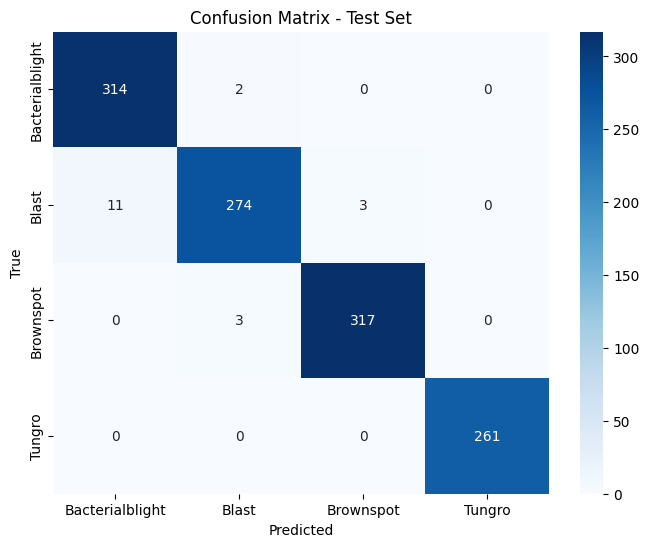

In [11]:
# Step 9: Classification report and confusion matrix
test_generator.reset()
test_preds = mobilenet_model.predict(test_generator)
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes

print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y_true, test_y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('./confusion_matrix_test.png')
plt.show()

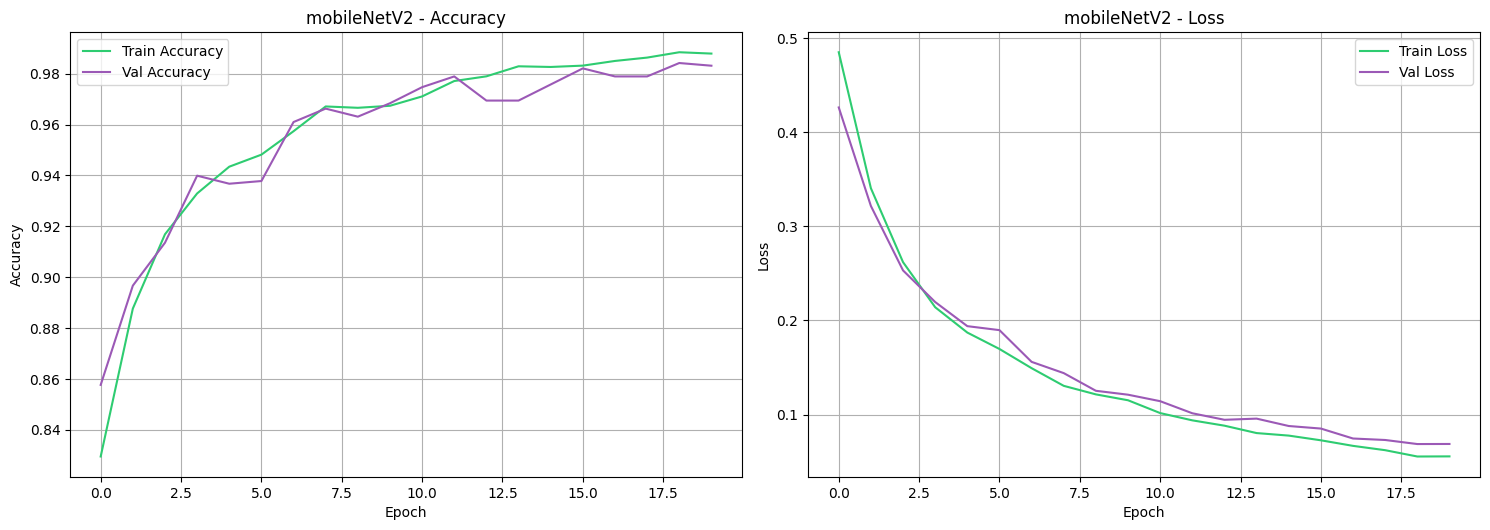

In [21]:
# Step 9: Plot training history 
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history.get('precision', [])
    val_precision = history.history.get('val_precision', [])
    recall = history.history.get('recall', [])
    val_recall = history.history.get('val_recall', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 10))
    
    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='#2ecc71')  # Green
    plt.plot(epochs_range, val_acc, label='Val Accuracy', color='#9b59b6')  # Purple
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='#2ecc71')
    plt.plot(epochs_range, val_loss, label='Val Loss', color='#9b59b6')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Precision plot
    if precision and val_precision:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, precision, label='Train Precision', color='#2ecc71')
        plt.plot(epochs_range, val_precision, label='Val Precision', color='#9b59b6')
        plt.title(f'{title} - Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)
    
    # Recall plot
    if recall and val_recall:
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, recall, label='Train Recall', color='#2ecc71')
        plt.plot(epochs_range, val_recall, label='Val Recall', color='#9b59b6')
        plt.title(f'{title} - Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('./training_history_efficientnet.png', dpi=300)
    plt.show()

plot_history(mobilenet_history, "mobileNetV2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test image: ./dataset\test\Blast\BLAST2_022.jpg
True class: Blast
Predicted class: Blast
Confidence: 0.9995


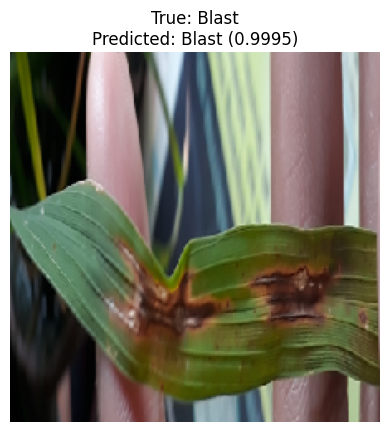

In [13]:
# Step 11: Test on a random image
model = tf.keras.models.load_model('./mobilenetv2_rice_leaf_best.h5')
image_paths = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

test_img_path = random.choice(image_paths)
img = load_img(test_img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]
true_class = os.path.basename(os.path.dirname(test_img_path))

print(f"Test image: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

plt.figure()
plt.imshow(img)
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('./test_result.png')
plt.show()

In [14]:
# Step 12: Save final model
mobilenet_model.save("./mobilenetv2_rice_final.h5")